In [1]:
from models.cnp import CNP
from data.data_generators import *
import torch

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
device = torch.device("cpu")

/home/yigit/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
import matplotlib.pyplot as plt

dx = 1
t_steps = 200
x = torch.linspace(0, 1, t_steps).view(-1, 1)

generator_functions = [generate_sin, generate_cos, generate_cx_sigm, 
    generate_reverse_cx_sigm]
y = []
for i in range(32):
    for j in range(4):
        y.append(generator_functions[j](x))

colors = ["b", "r", "g", "y"]
num_classes = 4
# for i, y_i in enumerate(y):
#     plt.plot(y_i, alpha=0.5, c=colors[i%num_classes])

x = x.unsqueeze(0).repeat(len(y), 1, 1).to(device)
y = torch.stack(y, dim=0).to(device)

print(x.shape, y.shape)

torch.Size([128, 200, 1]) torch.Size([128, 200, 1])


In [3]:
model = CNP().to(device)
optimizer = torch.optim.Adam(lr=1e-4, params=model.parameters())

In [6]:
def get_batch(x, y, traj_ids):
    n = x.shape[1]
    n_t = torch.randint(1, model.n_max_tar, (1,)).item()
    n_o = torch.randint(1, model.n_max_obs, (1,)).item()

    obs = torch.zeros(batch_size, n_o, model.input_dim+model.output_dim).to(device)
    tar = torch.zeros(batch_size, n_t, model.input_dim).to(device)
    tar_val = torch.zeros(batch_size, n_t, model.output_dim).to(device)

    for i in range(len(traj_ids)):
        random_query_ids = torch.randperm(n)
        o_ids = random_query_ids[:n_o]
        t_ids = random_query_ids[n_o:n_o+n_t]

        # print(x.shape, traj_ids[i], o_ids, t_ids)

        obs[i, :, :] = torch.cat((x[traj_ids[i], o_ids], y[traj_ids[i], o_ids]), dim=-1)
        tar[i, :, :] = x[traj_ids[i], t_ids]
        tar_val[i, :, :] = y[traj_ids[i], t_ids]

    return obs, tar, tar_val


batch_size = 32
epochs = 2500
epoch_iter = 4
min_loss = 1000000
avg_loss = 0

for epoch in range(epochs):
    epoch_loss = 0

    traj_ids = torch.randperm(x.shape[0]).chunk(epoch_iter)

    for i in range(epoch_iter):
        optimizer.zero_grad()
        obs, tar_x, tar_y = get_batch(x, y, traj_ids[i])
        pred, encoded_rep = model(obs, tar_x)
        loss = model.loss(pred, tar_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    if epoch_loss < min_loss and epoch > 5e4:
        min_loss = epoch_loss
        torch.save(model.state_dict(), f'cnp_on_latent_model.pt')

    avg_loss += epoch_loss

    if epoch % 100 == 0:
        print("Epoch: {}, Loss: {}".format(epoch, avg_loss/100))
        avg_loss = 0

Epoch: 0, Loss: 0.007445525601506233
Epoch: 100, Loss: 0.14672149170306512
Epoch: 200, Loss: -1.0893711518682538
Epoch: 300, Loss: -2.1737139506917447
Epoch: 400, Loss: -2.991160924914293
Epoch: 500, Loss: -3.4980013927444817
Epoch: 600, Loss: -3.961383874937892
Epoch: 700, Loss: -4.170349263735115
Epoch: 800, Loss: -4.336744393482804
Epoch: 900, Loss: -4.90832523311954
Epoch: 1000, Loss: -5.016798186213709
Epoch: 1100, Loss: -5.211480433990946
Epoch: 1200, Loss: -5.344090505894274
Epoch: 1300, Loss: -5.605139792710543
Epoch: 1400, Loss: -5.4330125986039635
Epoch: 1500, Loss: -5.733968786882906
Epoch: 1600, Loss: -5.9872975467517975
Epoch: 1700, Loss: -6.042100911485031
Epoch: 1800, Loss: -6.337012160718441
Epoch: 1900, Loss: -6.482782393395901
Epoch: 2000, Loss: -6.632371667325497
Epoch: 2100, Loss: -6.976678997073322
Epoch: 2200, Loss: -7.00452666502446
Epoch: 2300, Loss: -6.776889508739114
Epoch: 2400, Loss: -7.119122694805265


In [25]:
model = CNP().to(device)
model.load_state_dict(torch.load('cnp_on_latent_model.pt'))
model.eval()

batch_size = 128
o, t, tr = get_batch(x, y, torch.arange(batch_size))

with torch.no_grad():
    _, r = model(o, t)

print(r.shape)

torch.Size([128, 1, 256])


1.5
[0 3 2 1 0 3 2 1 0 3 2 1 0 3 2 1 0 3 2 1 0 3 2 1 0 3 2 1 0 3 2 1 0 3 2 1 0
 3 2 1 0 3 2 1 0 3 2 1 0 3 2 1 0 3 2 1 0 3 2 1 0 3 2 1 0 3 2 1 0 3 2 1 0 3
 2 1 0 3 2 1 0 3 2 1 0 3 2 1 0 3 2 1 0 3 2 1 0 3 2 1 0 3 2 1 0 3 2 1 0 3 2
 1 0 3 2 1 0 3 2 1 0 3 2 1 0 3 2 1]


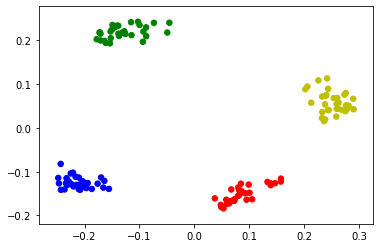

In [26]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

latent_values = r.squeeze(1).cpu().numpy()
kmeans = KMeans(n_clusters=4, random_state=100)
labels = kmeans.fit_predict(latent_values)

print(np.mean(labels), labels, sep='\n')
pca = PCA(n_components=2)
reduced_latent = pca.fit_transform(latent_values)

label_colors = []
for i in labels:
    label_colors.append(colors[i])
plt.scatter(reduced_latent[:, 0], reduced_latent[:, 1], c=label_colors, s=30)
